# Sartorius 

Dit is een onderzoek naar het autmoatiseren van de annotatie op hersen cellen.
Dit onderzoek is gestart om te zorgen dat doktoren meer tijd over hebben voor andere bezigheden.

Door groep 4
Danny Rovers, Thomas Hendriks en Liam Freke

In [1]:
#pip install opencv-python

In [280]:
import pandas as pd
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt
import sys
import cv2
import glob
import skimage.color
import skimage.filters
import seaborn as sns
import os
from tqdm.notebook import tqdm
import numpy as np
from PIL import Image as im
from PIL import ImageFilter
from sklearn import datasets
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB 

Als eerste wordt de data opgehaald. Wij beginnen daarmee door het csv bestandt train op te halen. Dit zie je in onderstaande code.

In [3]:
pad_naar_file = r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train.csv"
type(pad_naar_file)

str

In [4]:
def read_data(csv_file):
    dataframe = pd.read_csv(csv_file)

    #zet hier de code om de CSV file in te lezen
    return dataframe

In [5]:
#hier wordt jouw functie aangeroepen en bevat df nu het dataframe
df = read_data(pad_naar_file);

In [6]:
df

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
...,...,...,...,...,...,...,...,...,...
73580,ffdb3cc02eef,3610 3 4311 7 5014 9 5717 11 6420 13 7123 15 7...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73581,ffdb3cc02eef,341585 2 342287 5 342988 10 343690 13 344394 1...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73582,ffdb3cc02eef,47788 3 48490 7 49192 11 49896 13 50599 14 513...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73583,ffdb3cc02eef,333290 1 333993 2 334696 4 335399 5 336102 6 3...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00


In [7]:
potlood = df.loc[df['id'] == '0030fd0e6378'].annotation.tolist()
potlood

['118145 6 118849 7 119553 8 120257 8 120961 9 121665 10 122369 12 123074 13 123778 14 124482 15 125186 16 125890 17 126594 18 127298 19 128002 20 128706 21 129410 22 130114 23 130818 24 131523 24 132227 25 132931 25 133635 24 134339 24 135043 23 135748 21 136452 19 137157 16 137864 11 138573 4',
 '189036 1 189739 3 190441 6 191144 7 191848 8 192552 9 193256 10 193960 11 194664 11 195368 12 196072 12 196776 13 197480 13 198185 13 198889 13 199593 14 200297 13 201002 11 201706 10 202410 9 203115 7 203819 6 204523 5 205227 5 205932 3 206636 2 207340 1',
 '173567 3 174270 5 174974 5 175678 6 176382 7 177085 9 177789 9 178493 10 179197 11 179901 12 180605 12 181308 14 182012 15 182716 15 183420 16 184125 16 184831 15 185536 14 186241 14 186947 12 187651 13 188356 12 189061 12 189767 10 190472 10 191177 9 191883 7 192589 5 193295 2 194000 1',
 '196723 4 197427 6 198130 7 198834 8 199538 8 200242 9 200946 9 201650 10 202354 10 203058 10 203762 11 204466 11 205170 12 205874 12 206578 13 20728

Vanuit deze tabel hebben wij een data dictionary opgesteld.

### Data dictionary ###

| Variabele | Omschrijving | Datatype | Numeriek of Categorie | Meetniveau |
| :--- | :--- | :--- | :--- | :--- |
| Id | Een unieke identificatie code | Integer | Nummeriek | Ordinaal |
| annotation | gecodeerde pixels van een geïdentificeerde neuronen cell | object | Nummeriek | Ordinaal |
| width | breedte van de source image | Integer | Nummeriek | Interval |
| height | hoogte van de source image | Integer | Nummeriek | Interval |
| cell_type | Type van de cell | String | Catagorie | Nominaal |
| plate_time | Tijd van het maken van de sample | Time | Nummeriek | Interval |
| sample_date | Datum wanneer de sample is gemaakt | Date | Nummeriek | Interval |
| sample_id | Een unieke identificatie code van de sample | Integer | Catagorie | Ordinaal |
| elepased_timedelta | Tijd sinds eerste image is genomen | Date | Nummeriek | Ratio |

## Controleren van de data

Hierboven staat een deel van de data in het train csv bestandt. De data ziet er schoon uit maar wij zullen dit eerst testen voor de zekerheid. We zullen beginnen met het kijken naar de nullwaardes.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73585 entries, 0 to 73584
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 73585 non-null  object
 1   annotation         73585 non-null  object
 2   width              73585 non-null  int64 
 3   height             73585 non-null  int64 
 4   cell_type          73585 non-null  object
 5   plate_time         73585 non-null  object
 6   sample_date        73585 non-null  object
 7   sample_id          73585 non-null  object
 8   elapsed_timedelta  73585 non-null  object
dtypes: int64(2), object(7)
memory usage: 5.1+ MB


Hierboven staat de info over de tabel. Hierin staat ook dat er geen nullwaardes bevinden in de data. Verder zien we ook dat de data types van de kolommen goed staan. We zullen nu kijken naar alle unieke catagorische data.

In [9]:
df['cell_type'].unique()

array(['shsy5y', 'astro', 'cort'], dtype=object)

In [10]:
df['plate_time'].unique()

array(['11h30m00s', '09h00m00s', '13h30m00s', '19h30m00s', '07h30m00s',
       '11h59m00s', '01h30m00s', '13h00m00s'], dtype=object)

In [11]:
df['sample_date'].unique()

array(['2019-06-16', '2020-09-13', '2020-11-04', '2020-10-27',
       '2020-11-07', '2019-06-14', '2019-06-15', '2020-11-03',
       '2020-11-06', '2020-10-30', '2020-11-05', '2020-09-15',
       '2020-09-16', '2020-09-14', '2020-09-12', '2020-10-26',
       '2020-11-01', '2020-10-29'], dtype=object)

In [12]:
df['elapsed_timedelta'].unique()

array(['0 days 11:30:00', '0 days 09:00:00', '0 days 13:30:00',
       '0 days 19:30:00', '0 days 07:30:00', '0 days 11:59:00',
       '0 days 01:30:00', '0 days 13:00:00'], dtype=object)

In [13]:
df['width'].unique()

array([704], dtype=int64)

In [14]:
df['height'].unique()

array([520], dtype=int64)

In [15]:
df["id"].value_counts(normalize=False)

c4121689002f    790
d164e96bb7a9    782
e748ac1c469b    703
aff8fb4fc364    609
e8ae919aa92e    605
               ... 
7f21996da2e6      8
c25db38e918e      6
b861811eaff6      5
eec79772cb99      5
e92c56871769      4
Name: id, Length: 606, dtype: int64

In [16]:
df["sample_id"].value_counts(normalize=False)

shsy5y[diff]_E10-3_Vessel-714_Ph_4    1463
shsy5y[diff]_D11-2_Vessel-714_Ph_3    1313
shsy5y[diff]_D11-2_Vessel-714_Ph_1    1233
shsy5y[diff]_D11-1_Vessel-714_Ph_4    1230
shsy5y[diff]_D12-4_Vessel-714_Ph_4    1181
                                      ... 
astro[hippo]_G1-4_Vessel-361_Ph_3       11
astro[hippo]_F3-3_Vessel-361_Ph_1       10
cort[6-OHDA]_B1-2_Vessel-377_Ph_2        9
cort[6-OHDA]_G2-1_Vessel-377_Ph_4        8
astro[hippo]_H6-4_Vessel-361_Ph_4        5
Name: sample_id, Length: 403, dtype: int64

De catagorische data toont ons hoeveel verschillende waardes voorkomen.
Nu zullen wij de waardes van "cell_type" omzetten naar getallen omdat dit beter werkbaar is voor onze analyse.
De waardes "width" en "height" hebben beide maar één waarde.
De waardes "id" komt meerdere keren voor. Dit kan omdat er op meerdere pixels op de foto's van de data set markerkingen kunnen staan.
De waarde "sample_id" komt ook meerdere keren voor. Deze waarde komt vaker voor dan "id" en geeft aan dat er waarschijnlijk van een monster meerdere foto's zijn gemaakt.
Verder zien we geen andere opmerkelijke dingen in de data staan.
De andere waardes laten wij voor nu staan.

In [17]:
def vervang_categorienaam(dataframe):
    set_wc = {'shsy5y':0,'astro':1,'cort':2}
    dataframe['cell_type'] = dataframe['cell_type'].map(set_wc)
    return dataframe

In [18]:
df = vervang_categorienaam(df)

We gaan nu verder met het bekijken van de correlaties in de data.

<AxesSubplot:>

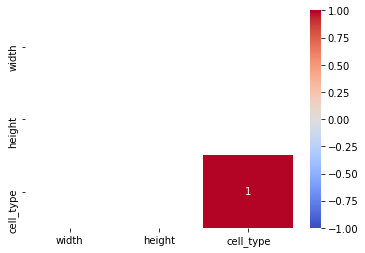

In [19]:
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

Hierboven staat een lege heatmap. Dit geeft aan dat er geen correlaties bevinden in de data. Nu zullen wij verder kijken naar de verdeling van de data we beginen met cell_type

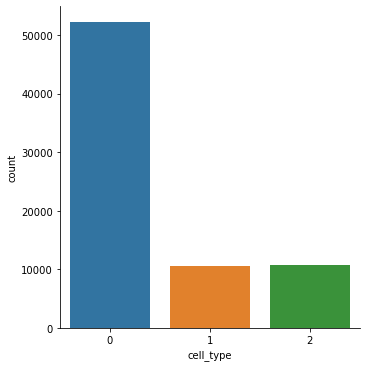

In [20]:
sns.catplot(x='cell_type', data=df,kind='count')  

Hierin valt goed te zien dat de shsy5y cell het meeste voor komt. Hierna komen de andere twee cellen die dicht bij elkaar liggen. Nu zullen we kijken naar de kolommen "elapsed_timedelta", "sample_date" en "plate_time".

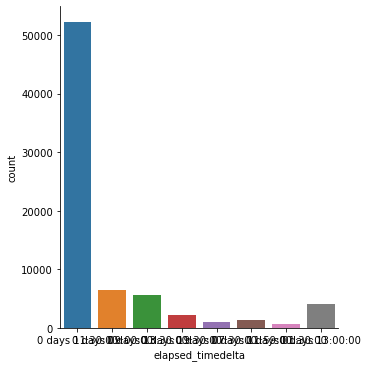

In [21]:
sns.catplot(x='elapsed_timedelta', data=df,kind='count')

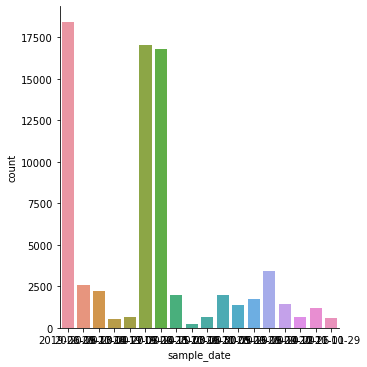

In [22]:
sns.catplot(x='sample_date', data=df,kind='count')

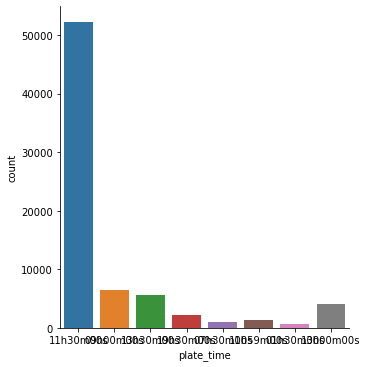

In [23]:
sns.catplot(x='plate_time', data=df,kind='count')

Bovenstaande grafieken geven aan dat de proeven of monsters vaak rond dezelfde tijd gedaan zijn. We gaan nu verder met het verwijderen van kolommen die niet nuttig zijn voor het onderzoek.

In [24]:
def verwijder(dataframe):
    dataframe = df.drop(['elapsed_timedelta'], axis=1)
    dataframe = df.drop(['sample_date'], axis=1)
    dataframe = df.drop(['plate_time'], axis=1)
    dataframe = df.drop(['width'], axis=1)
    dataframe = df.drop(['height'], axis=1)
    return dataframe

In [25]:
df = verwijder(df)

Wij hebben ervoor gekozen om de kolommen "elapsed_timedelta", "sample_date" en "plate_time" te verwijderen omdat dit tijd aangeeft. Dit hebben wij niet nodig voor oons onderzoek. 
Verder hebben wij "Width"en "height" verwijderd. Deze kolommen hebben beide maar 1 waarde en is daarom niet nuttig voor ons om mee te nemen in het onderzoek. Hieronder staat een voorbeeld van de uiteindelijke data set.

In [26]:
df.head(10)

,id,annotation,width,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
5,0030fd0e6378,205984 2 206687 4 207391 5 208095 5 208799 6 2...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
6,0030fd0e6378,203101 2 203805 5 204509 7 205213 10 205917 12...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
7,0030fd0e6378,191900 2 192604 3 193308 4 194012 5 194717 5 1...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
8,0030fd0e6378,184848 3 185551 5 186254 7 186958 8 187662 9 1...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
9,0030fd0e6378,165119 1 165822 4 166526 6 167230 9 167935 9 1...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [27]:
test_set_raw = r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\test"
train_set_raw = r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train"
train_semi_set_raw = r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train_semi_supervised"

In [28]:
def Show_image(path):
    filterwarnings("ignore") 
    tf_img = io.read_file(path)
    tf_img = image.decode_png(tf_img, channels=3)
    #plt.imshow(tf_img)
    return tf_img

In [29]:
def get_img(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in tqdm(filenames):
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
        return image_names

In [30]:
def display_multiple_img(images_paths, rows, cols):
    """
    Function to Display Images from Dataset.
    
    parameters: images_path(string) - Paths of Images to be displayed
                rows(int) - No. of Rows in Output
                cols(int) - No. of Columns in Output
    """
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(16,8) )
    for ind,image_path in enumerate(images_paths):
        image=cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

In [31]:
test_set = get_img(test_set_raw)
train_set = get_img(train_set_raw)
train_semi_set = get_img(train_semi_set_raw)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/606 [00:00<?, ?it/s]

  0%|          | 0/1972 [00:00<?, ?it/s]

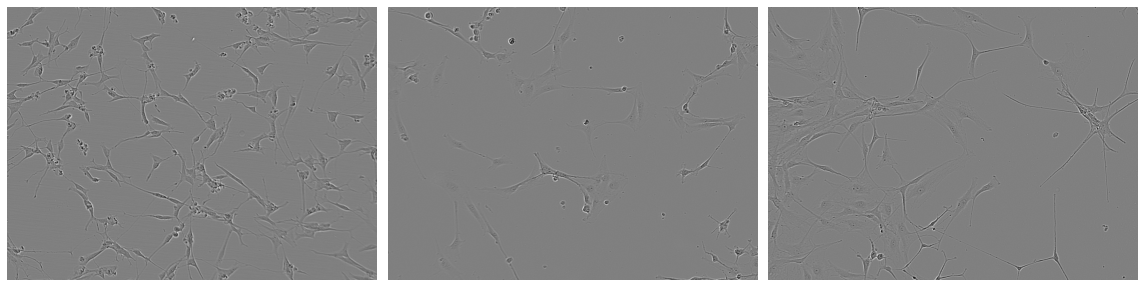

In [32]:
display_multiple_img(test_set,1,3)

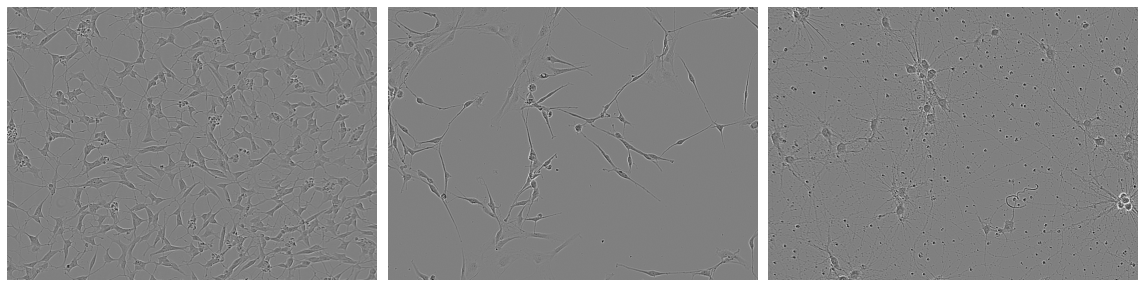

In [33]:
display_multiple_img(train_set,1,3)

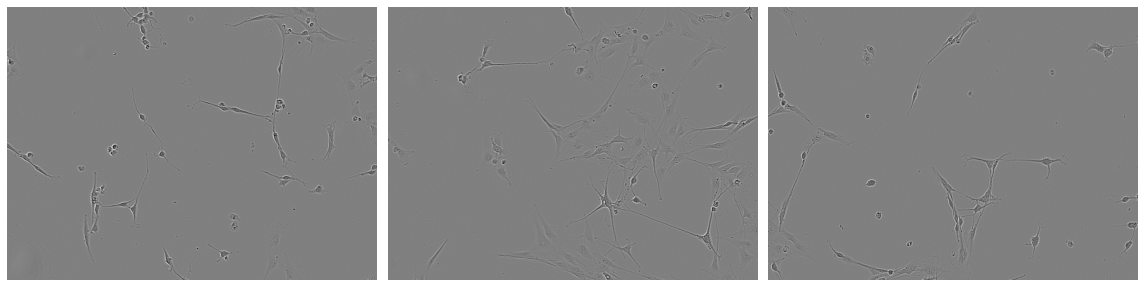

In [34]:
display_multiple_img(train_semi_set,1,3)

In [35]:
imageObject = im.open(r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train\ffdb3cc02eef.png");
imageObject.show();

In [36]:
sharpened1 = imageObject.filter(ImageFilter.SHARPEN)
sharpened2 = sharpened1.filter(ImageFilter.SHARPEN)

In [37]:
# sharpened1.show()
# sharpened2.show()

In [38]:
def sharpen(image, aantal):
    imageObject = im.open(image)
    i = 0
    while i > aantal:
        imageObject = imageObject.filter(ImageFilter.SHARPEN)
        imageObject.show()
        i = i + 1
    return imageObject

In [39]:
testImg = plt.imread(r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train\ffdb3cc02eef.png")

In [40]:
testImg.shape

(520, 704)

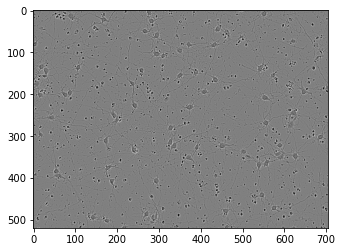

In [41]:
plt.imshow(testImg,cmap='gray')
plt.show()

In [42]:
# Hier maken we de twee kernels aan
Gx = np.matrix([[1,2,1],[0,0,0],[-1,-2,-1]])
Gy = np.matrix.transpose(Gx)
print(Gx)
print(Gy)

[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]
[[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]


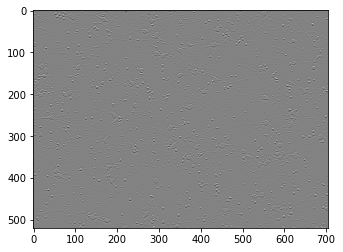

In [43]:
# Pas beide kernels toe in horinzontale en verticale richting
edgex = cv2.filter2D(testImg,-1,Gx)
edgey = cv2.filter2D(testImg,-1,Gy)
plt.imshow(edgex,cmap='gray')
plt.show()

In [44]:
# Neem de som van de kernels en daar de wortel uit. 
w = np.sqrt(np.square(edgex)+np.square(edgey))

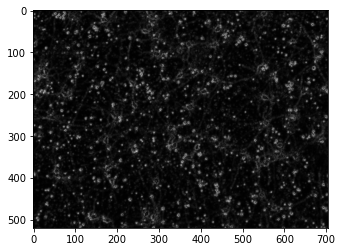

In [45]:
plt.imshow(w,cmap='gray')
plt.show()

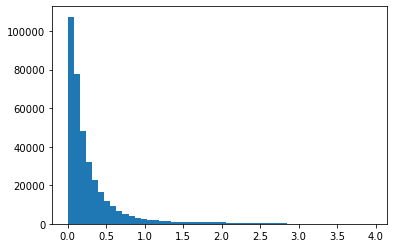

In [46]:
# Gebruik hier thresholding om de edges duidelijker te maken. 
plt.hist(w.flatten(),bins=50)
plt.show()

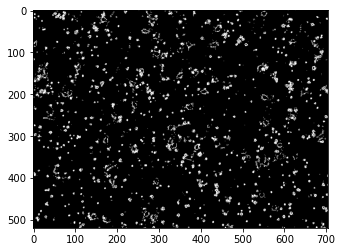

In [47]:
plt.imshow(w>1.0,cmap='gray')
plt.show()

## edge detection

In [48]:
testImg1 = r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train\0030fd0e6378.png"
testTrain = r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train"

(Text(0.5, 1.0, 'Edge Image'), ([], []), ([], []))

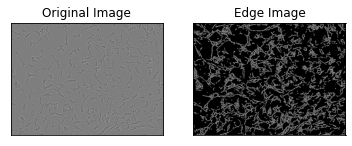

In [49]:
img = cv2.imread(testImg1,0)
edges = cv2.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

In [50]:
edges = cv2.Canny(img, 100, 200)

row_indexes, col_indexes = np.nonzero(edges)

## maken array voor mask

In [51]:
array = []

In [52]:
tel = 0
predict_mask = []
for i in row_indexes:
    predict_mask.append(i)
    predict_mask.append(col_indexes[tel])
    tel = tel + 1

In [53]:
image_array= []
a = []
groote = 519
i = 0
while i <= 519:
    a = []
    image_array.append(a)
    i = i +1

In [54]:
i = 0
while i <= 519:
    o = 0
    while o <= 703:
        a = []
        image_array[i].append(a)
        o = o+1
    i = i +1

In [55]:
for i in image_array:
    for r in i:
            r.append(0.)
            r.append(0.)
            r.append(0.)

In [56]:
getal = 519
i= 0
lengte = len(predict_mask)
lengte = lengte - 1
while i <= lengte:
    rij = predict_mask[i]
    kolom = predict_mask[i+1]
    image_array[rij][kolom].clear()
    image_array[rij][kolom].append(1.)
    image_array[rij][kolom].append(1.)
    image_array[rij][kolom].append(1.)
    i = i + 2

In [57]:
image_array = np.array(image_array)

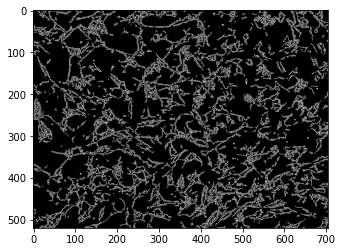

In [58]:
image_array = np.reshape(image_array, (520,704,-1))
plt.imshow(image_array)
plt.show()

## annotations ophalen

In [59]:
def decode_rle_to_mask(rle, height, width, color, viz=False):
    rle = np.array(rle.split(' ')).reshape(-1, 2)
    mask = np.zeros((height*width, 1, 3))
    if viz:
        color = color
    else:
        color = color
    for i in rle:
        mask[int(i[0]):int(i[0])+int(i[1]), :, :] = color

    return mask.reshape(height, width, 3)

In [60]:
example_id = "0030fd0e6378.png" # change the example id for different images
example_id2 = "0030fd0e6378"

[[[146 146 146]
  [154 154 154]
  [147 147 147]
  ...
  [123 123 123]
  [128 128 128]
  [133 133 133]]

 [[159 159 159]
  [154 154 154]
  [135 135 135]
  ...
  [137 137 137]
  [138 138 138]
  [139 139 139]]

 [[128 128 128]
  [131 131 131]
  [121 121 121]
  ...
  [130 130 130]
  [126 126 126]
  [125 125 125]]

 ...

 [[135 135 135]
  [127 127 127]
  [127 127 127]
  ...
  [114 114 114]
  [112 112 112]
  [129 129 129]]

 [[144 144 144]
  [141 141 141]
  [131 131 131]
  ...
  [118 118 118]
  [103 103 103]
  [111 111 111]]

 [[125 125 125]
  [142 142 142]
  [144 144 144]
  ...
  [141 141 141]
  [137 137 137]
  [127 127 127]]]
(520, 704, 3)
This is the image we are going to use, id:- C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train\0030fd0e6378.png


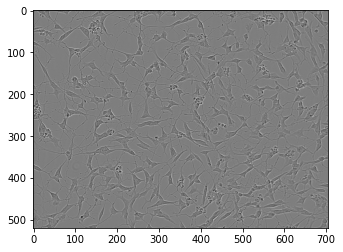

In [61]:
example_id = testImg1 # change the example id for different images
image = cv2.imread(os.path.join(train_set_raw,example_id))
print(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = (image-np.min(image))/(np.max(image)-np.min(image))
print(image.shape)
print("This is the image we are going to use, id:-", example_id)
plt.imshow(image)
plt.show()

In [62]:
# example_annot = df[df.id==example_id2].annotation.values[0]
# print("The Annotation : ",example_annot)
# print("Now let's convert it to mask and view it")
# mask1 = decode_rle_to_mask(example_annot, image.shape[0], image.shape[1], viz=False)
# print(image.shape[0], image.shape[1],)
# plt.imshow(mask1)
# plt.show()

In [63]:
# example_id_annotations = df[df.id==example_id2].annotation.values
# masks = np.zeros(image.shape)
# for each_cell_annot in example_id_annotations:
#     mask = decode_rle_to_mask(each_cell_annot, image.shape[0], image.shape[1])
#     masks+=mask

# plt.imshow(image)
# plt.show()
# plt.imshow(masks)
# plt.show()
# t = image+masks
# plt.imshow(t)
# plt.show()

## berekenen score

In [64]:
# getal = 519
# getal2 = 703
# i=0
# j=0
# resultaten = []
# while i <= getal:
#     while j <= getal2:
#         m = tf.keras.metrics.MeanIoU(num_classes=2)
#         if masks[i][j][0] == 2.0:
#             masks[i][j] = [1., 1., 1.]
#         m.update_state(masks[i][j], image_array[i][j])
#         resultaten.append(m.result().numpy())
#         j = j +1
#     i = i + 1

In [65]:
# score = sum(resultaten)/(i*j)

In [66]:
# score

## Edge detection over alle images

In [67]:
train_folder = r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train"

In [68]:
def mask_maken(row_indexes,col_indexes):
    #inlezen 1 waardes voor de mask
    array = []
    tel = 0
    predict_mask = []
    for i in row_indexes:
        predict_mask.append(i)
        predict_mask.append(col_indexes[tel])
        tel = tel + 1
    # aanmaken array met juiste aantal rijen
    image_array= []
    a = []
    groote = 519
    i = 0
    while i <= 519:
        a = []
        image_array.append(a)
        i = i +1
    # aanmaken array met juiste aantal kolomen
    i = 0
    while i <= 519:
        o = 0
        while o <= 703:
            a = []
            image_array[i].append(a)
            o = o+1
        i = i +1
    # vullen array
    for i in image_array:
        for r in i:
                r.append(0.)
                r.append(0.)
                r.append(0.)
    # toevoegen mask aan array
    getal = 519
    i= 0
    lengte = len(predict_mask)
    lengte = lengte - 1
    while i <= lengte:
        rij = predict_mask[i]
        kolom = predict_mask[i+1]
        image_array[rij][kolom].clear()
        image_array[rij][kolom].append(1.)
        image_array[rij][kolom].append(1.)
        image_array[rij][kolom].append(1.)
        i = i + 2
    return image_array

In [69]:
def score_berekenen(masks, image_array):
    getal = 519
    getal2 = 703
    i=0
    j=0
    resultaten = []
    #
    while i <= getal:
        while j <= getal2:
            m = tf.keras.metrics.MeanIoU(num_classes=2)
            if masks[i][j][0] == 2.0:
                masks[i][j] = [1., 1., 1.]
            m.update_state(masks[i][j], image_array[i][j])
            resultaten.append(m.result().numpy())
            j = j +1
        i = i + 1
    return resultaten

In [70]:
def create_masks():

    masks_dict = {}
    name_number = 1

    # For every unique id in the training data set 
    for image_id in df['id'].head(1500).unique():
        
        # Create base mask
        ground_mask = np.zeros(np.array([520, 704, 3]))

        # For each seperate annotation / row
        for each_cell_annot in df[df.id==image_id].annotation.values:
            
            # Decode annotation and create mask
            mask = decode_rle_to_mask(each_cell_annot, 520, 704, 1)
            
            # Add mask to starting mask
            ground_mask+=mask
            
        print(f"Added to dictionary: {f'masks{name_number}'} created with id: {image_id}")
        
        # Add completed mask to dictionary
        masks_dict[f"masks{name_number}"] = ground_mask
        
        name_number+=1
        
    return masks_dict

In [71]:
# masks_dict = create_masks()

In [72]:
# i = 0
# nummer = 1
# scores = []
# #foto's uit de test map laden.
# for foto in os.listdir(train_folder):
#     img = cv2.imread(train_folder + "\\" + foto)
#     #edge detection
#     edges = cv2.Canny(img,100,200)
#     row_indexes, col_indexes = np.nonzero(edges)
#     # dit weghalen als alle foto's gedaan moeten worden
#     if i <= 4:
#         voorspel_mask = mask_maken(row_indexes,col_indexes)
#         resultaten = score_berekenen(masks_dict[f'masks{nummer}'], voorspel_mask)
#         score = sum(resultaten)/(519*703)
#         scores.append(score)
#         i = i + 1
#         nummer = nummer + 1
#         print(foto)
# print(scores)

In [73]:
# masks_dict.keys()

In [74]:
def decode_rle_to_mask(rle, height, width, color, viz=False):
    rle = np.array(rle.split(' ')).reshape(-1, 2)
    mask = np.zeros((height*width, 1, 3))
    if viz:
        color = np.random.rand(3)
    else:
        color = color
    for i in rle:
        mask[int(i[0]):int(i[0])+int(i[1]), :, :] = color

    return mask.reshape(height, width, 3)

In [75]:
def create_masks(source, unique_number = None):
    
    # unique_number : specifies number of unique ids to get
    # source : specifies the source variable (dataframe)
    
    masks_dict = {}

    if unique_number == None:
        unique_id = source['id'].unique()
    else:
        unique_id = source['id'].unique()[:unique_number]
        
    # Create tqdm progress bar
    bar_loop = tqdm(unique_id)
    
    # For every unique id in the data set 
    for image_id in bar_loop:
        bar_loop.set_description("Processing Mask: %s" % image_id)
        
        # Create base mask
        ground_mask = np.zeros(np.array([520, 704, 3]))

        # For each separate annotation / row
        for each_cell_annot in source[source.id==image_id].annotation.values:
            
            # Decode annotation and create mask
            mask = decode_rle_to_mask(each_cell_annot, 520, 704, 1)
            
            # Add mask to starting mask
            ground_mask+=mask
        
        # Add completed mask to dictionary
        masks_dict[image_id] = ground_mask
        
    return masks_dict

In [76]:
def getimage(image_id):
    image = cv2.imread(os.path.join(train_folder, image_id)+'.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [232]:
def create_new_mask(row_indexes,col_indexes):
    
    predict_mask = []
    index = 0
    
    # Create mask from row index
    for pixel in row_indexes:
        predict_mask.append(pixel)
        predict_mask.append(col_indexes[index])
        index+=1
    
    # Create empty numpy array
    image_array = np.zeros((520, 704, 3), dtype=float)
    
    # Add mask to array
    for i in range(0, len(predict_mask), 2):
        row, col = predict_mask[i], predict_mask[i+1]
        image_array[row][col] = [1., 1., 1.]
    
    plt.imshow(image_array)
    
    return image_array

In [233]:
def calculate_iou(ground_truth, prediction):
    
    # Calculate intersection
    intersection = np.logical_and(prediction, ground_truth).sum()
    
    # Calculate union
    union = np.logical_or(prediction, ground_truth).sum()
    
    # Calculate IoU
    iou = intersection / union
    
    return iou

In [234]:
def canny_edge(image):
    edges = cv2.Canny(image,100,200)
    edges = np.nonzero(edges)
    return edges

In [267]:
def tresholding(image):
    #turn pixels te gray values
    grijs = skimage.color.rgb2gray(testTres)

    # blur the image to denoise
    blurred = skimage.filters.gaussian(grijs, sigma=1.0)
    
    # calulating treshold values
    t = skimage.filters.threshold_otsu(blurred)
    
    # apply mask to picture
    mask = blurred > t
    
    # apply mask to orgininal picture
    cellen = image.copy()
    cellen[~mask] = 0
    
    j = 0
    col_indexes = []
    row_indexes = []
    # iterate trough rows
    while j <= len(cellen) - 1:
        i = 0
        # iterate trough columns 
        while i <= len(cellen[0]) -1:
            waarde = cellen[j][i][0]
            # get the pixel value
            # the values kan be adjusted between 0/255 <= waarde <= 0/255
            if 120 >= waarde <= 150:
                col_indexes.append(i)
                row_indexes.append(j)
            i = i + 1
        j = j + 1 
            
    row_indexes = np.array(row_indexes)
    col_indexes = np.array(col_indexes)
    totaal = row_indexes,col_indexes
    
    return totaal

In [236]:
def image_altering(data, alter_function):
    
    print(alter_function)
    key_image = {}
    altered_images = {}
    
    # Get images from key (dict or list)
    if type(data) == dict:
        for k in data.keys():
            key_image[k] = getimage(k)
    elif type(data) == list:
        for k in data:
            key_image[k] = getimage(k)
    else:
        print('Data needs to be Dict or List')
    
    # Create tqdm progress bar
    bar_loop_data = tqdm(key_image)
    
    for k in bar_loop_data:
        bar_loop_data.set_description("Converting Image: %s" % k)
    
        # image processing techinique used to alter image (must be function)
        altered_images[k] = alter_function(key_image[k])
        
    return altered_images

In [237]:
def create_alter_mask(altered_images):
    # Define indexes
    row_indexes, col_indexes = altered_images
    # Create prediction mask
    predict_mask = create_new_mask(row_indexes,col_indexes)
        
    return predict_mask

In [238]:
def compare_masks(masks_dict, altered_images): 
    # Create tqdm progress bar
    bar_loop_keys = tqdm(altered_images)
    score_dict = {}

    # For every key in dict 
    for key in bar_loop_keys:
        bar_loop_keys.set_description("Calculating Score:\t %s" % key)

        # Create prediction mask
        predict_mask = np.array(create_alter_mask(altered_images[key]))

        # Calculate IoU
        score = calculate_iou(masks_dict[key], predict_mask)

        score_dict[key] = score
        
    return score_dict

  0%|          | 0/2 [00:00<?, ?it/s]

<function tresholding at 0x000001BE6E2FB9D0>


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0030fd0e6378 : 0.28832390289513304
0140b3c8f445 : 0.22209674770039423

Average Score: 0.25521032529776366


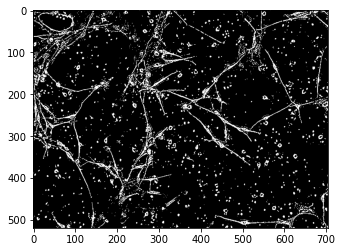

In [302]:
# variables: df source and optional number of unique ids (default = all)
masks_dict = create_masks(df,2)

# Alter images with image processing techniques (variable dict or list with Ids and image altering function)
altered_images = image_altering(masks_dict, tresholding)

# Compare original mask and created mask
dikkedict = compare_masks(masks_dict, altered_images)

for k, v in dikkedict.items():
    print(f"{k} : {v}")

print(f"\nAverage Score: {sum(dikkedict.values()) / len(dikkedict)}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


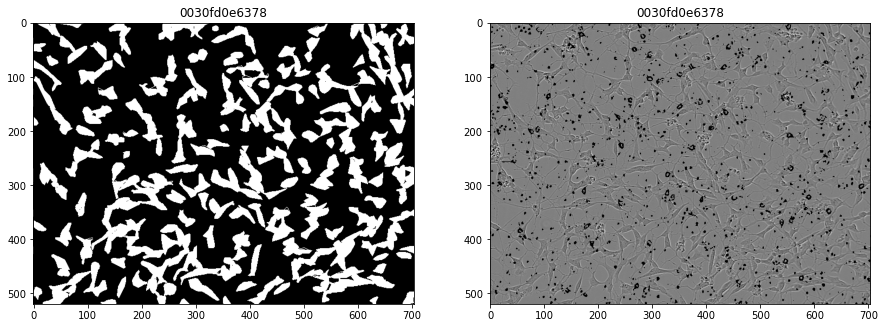

In [128]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 15)

# Get first key
#key = list(masks_dict.keys())[4]
key = '0030fd0e6378'
images = [masks_dict[key], altered_images[key]]
plot = 0

for i in images:
    ax[plot].imshow(i, cmap='gray')
    ax[plot].set_title(key)
    plot+=1

## Tresholding

Hiervoor wordt dezelfde foto gebruikt als edge detection

In [90]:
#testTres = plt.imread(r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train\ffdb3cc02eef.png")
testTres = cv2.imread(r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train\ffdb3cc02eef.png")
testTres = cv2.cvtColor(testTres, cv2.COLOR_BGR2RGB)

In [91]:
grijs = skimage.color.rgb2gray(testTres)

In [92]:
blurred = skimage.filters.gaussian(grijs, sigma=1.0)

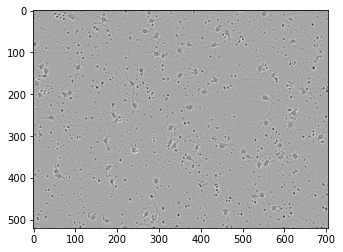

In [93]:
plt.imshow(blurred, cmap="gray")

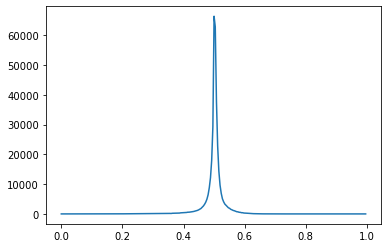

In [94]:
histogram, bin_edges = np.histogram(blurred, bins=256, range=(0.0, 1.0))
plt.plot(bin_edges[0:-1], histogram)

de grijs waarde zijn bijna normaal verdeeld en het betekent dus dat de foto veel grijs bevat wat ook te zien is.

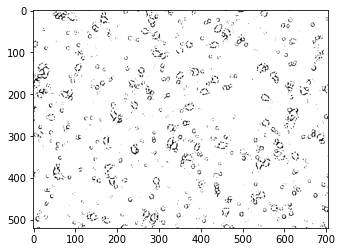

In [95]:
t = 0.55
mask = blurred < t
plt.imshow(mask, cmap="gray")

Door het donkere grijs weg te halen houden we alleen nog plekken over waar cellen zouden kunnen zitten.

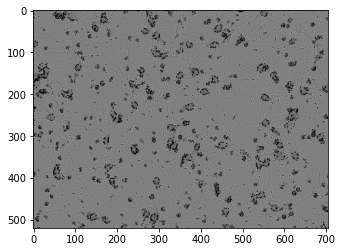

In [96]:
cellen = testTres.copy()
cellen[~mask] = 0

plt.imshow(cellen)

## cordinaten van kleur uit de foto halen.

In [97]:
im_array = np.array(cellen)

In [98]:
coordinates = np.where(im_array == [0, 0, 255])

In [99]:
from PIL import Image
import numpy as np

# Open the image
im = Image.open(r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train\ffdb3cc02eef.png")

# Convert the image to a numpy array
im_array = np.array(im)

In [100]:
# Create a binary image with a threshold of 100
threshold_image = np.where(im_array < 100, 255, 0)

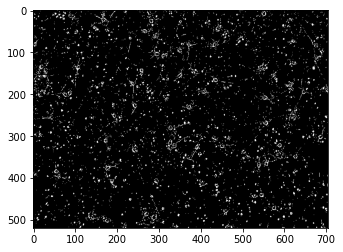

In [101]:
plt.imshow(threshold_image, cmap="gray")

Hieronder worden de rij en kolom geprint die witte waardes bevatten.

In [102]:
coordinates = np.where(threshold_image == [0, 255, 0])

<ipython-input-102-dc5ed282825b>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  coordinates = np.where(threshold_image == [0, 255, 0])


In [103]:
def create_alter_mask(altered_images, alter_function):
    if alter_function == 'tresholding':
        j = 0
        col_indexes = []
        row_indexes = []
        # iterate trough rows
        while j <= len(altered_images) - 1:
            i = 0
            # iterate trough columns 
            while i <= len(altered_images[0]) -1:
                waarde = altered_images[j][i][0]
                # get the pixel value
                # the values kan be adjusted between 0/255 <= waarde <= 0/255
                if 50 <= waarde <= 255:
                    col_indexes.append(i)
                    row_indexes.append(j)
                i = i + 1
            j = j + 1 
            
        row_indexes = np.array(row_indexes)
        col_indexes = np.array(col_indexes)
        predict_mask = create_new_mask(row_indexes,col_indexes)
        return predict_mask
    
    if alter_function == 'canny_edge':
        print("hier")
        # Define indexes
        row_indexes, col_indexes = np.nonzero(altered_images)
        print(len(row_indexes), len(col_indexes))
        # Create prediction mask
        predict_mask = create_new_mask(row_indexes,col_indexes)
        
        return predict_mask

In [104]:
index = 0
for pixel in row_indexes:
        predict_mask.append(pixel)
        predict_mask.append(col_indexes[index])
        index+=1

### Automatisch tresholden

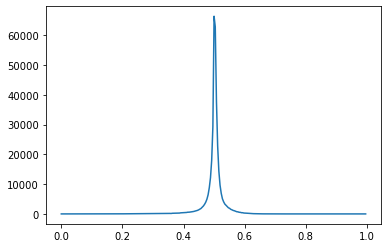

In [105]:
grijs = skimage.color.rgb2gray(testTres)

# blur the image to denoise
blurred = skimage.filters.gaussian(grijs, sigma=1.0)

histogram, bin_edges = np.histogram(blurred, bins=256, range=(0.0, 1.0))
plt.plot(bin_edges[0:-1], histogram)

In [106]:
t = skimage.filters.threshold_otsu(blurred)
print("Gevonden treshold = {}.".format(t))

Gevonden treshold = 0.4388206386425426.


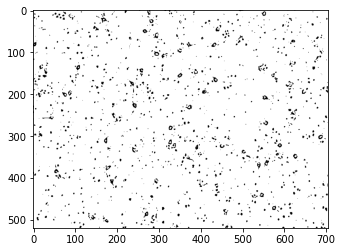

In [107]:
mask = blurred > t

fig, ax = plt.subplots()
plt.imshow(mask, cmap="gray")

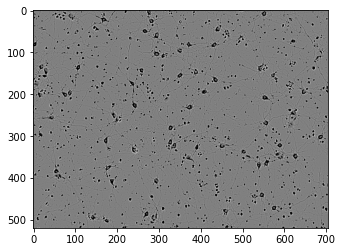

In [108]:
cellen = testTres.copy()
cellen[~mask] = 0

fig, ax = plt.subplots()
plt.imshow(cellen)

In [161]:
cellen[2]

array([[126, 126, 126],
       [128, 128, 128],
       [130, 130, 130],
       ...,
       [129, 129, 129],
       [130, 130, 130],
       [131, 131, 131]], dtype=uint8)

In [125]:
np.unique(cellen, return_counts=True)

(array([  0,  24,  25,  26,  28,  29,  33,  37,  38,  41,  42,  43,  44,
         45,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
         59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
         72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
        111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
        124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
        137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
        150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
        163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
        176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
        189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
        202, 203, 204, 205, 206, 207, 208, 209, 210

In [157]:
j = 0
col_indexes = []
row_indexes = []
rij = False
while j <= len(cellen) - 1:
    i = 0
    while i <= len(cellen[0]) -1:
        waarde = cellen[j][i][0]
        waarde1 = cellen[j][i][1]
        waarde2 = cellen[j][i][2]
        # pixel waarde eruit halen.
        # de waarde kan aangepast worden naar 0/255 <= waarde <= 0/255
        if 100 <= waarde <= 145 and 100 <= waarde1 <= 145 and 100 <= waarde2 <= 145:
            col_indexes.append(i)
            rij = True
        i = i + 1
    if rij == True:
        row_indexes.append(j)
        rij = False
    j = j + 1

## Naive Bayes

In [271]:
model = GaussianNB()

In [281]:
testNB = cv2.imread(r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train\0030fd0e6378.png")
trainNB = cv2.imread(r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train\0140b3c8f445.png")

In [282]:
testNB_y = masks_dict[key]

In [300]:
testNB = testNB.reshape(-1,1)
testNB_y = testNB_y.reshape(-1,1)

In [301]:
model.fit(testNB, testNB_y)

C:\Users\liamf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GaussianNB()

## test onzin

In [ ]:
ga kapot

In [ ]:
def run_length_decoding(compressed_seq):
  seq = ''
  for i in range(0,len(compressed_seq)):
    if compressed_seq[i].isalpha() == True:
      for j in range(int(compressed_seq[i+1])):
        seq += compressed_seq[i]
 
  return(seq)

In [ ]:
run_length_decoding(example_annot)

In [ ]:
array = row_indexes,col_indexes

In [ ]:
def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
def run_length_encoding(seq):
  compressed = []
  count = 1
  char = seq[0]
  for i in range(1,len(seq)):
    if seq[i] == char:
      count = count + 1
    else :
      compressed.append([char,count])
      char = seq[i]
      count = 1
  compressed.append([char,count])
  return compressed

In [ ]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height, width, channels) of array to return
    color: color for the mask
    Returns numpy array (mask)

    '''
    s = mask_rle.split()

    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]
    if len(shape)==3:
        img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    else:
        img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for start, end in zip(starts, ends):
        img[start : end] = color

    return img.reshape(shape)

In [ ]:
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))